Titanic - Machine Learning from Disaster

Start here! Predict survival on the Titanic and get familiar with ML basics

https://www.kaggle.com/competitions/titanic/data?select=train.csv



In [2]:
# Import panda dataframe library
import pandas as pd
import numpy as np
import torch as torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
# Open the train and test datasets to determine which features are available in each dataset
train_df = pd.read_csv('datasets/titanic/train.csv')
test_df = pd.read_csv('datasets/titanic/test.csv')

In [4]:
# print the first 7 rows of the train dataset
train_df.head(7)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S


In [5]:
# create target tensors
target = train_df['Survived'].values
target = torch.from_numpy(target)

In [6]:
def get_features(df):
    pclass = df['Pclass'].values
    num_train_examples = len(df)

    pgenders = df ['Sex'].values
    genders = []

    for pgen in pgenders:
        if pgen == 'male':
            genders.append(0)
        elif pgen == 'female':
            genders.append(1)

    genders = torch.tensor(genders)
    genders = genders.view(num_train_examples, -1)
    pclass = torch.tensor(pclass)
    pclass = pclass.view(num_train_examples, -1)
    features = torch.hstack((pclass, genders))
    features = features.view(num_train_examples, -1)

    df['Age'].fillna(df['Age'].median(), inplace=True)
    ages = df['Age'].values
    ages = torch.tensor(ages)
    ages = ages.view(num_train_examples, -1)
    features = torch.hstack((features, ages))

    sibsp = df['SibSp'].values
    sibsp = torch.tensor(sibsp)
    sibsp = sibsp.view(num_train_examples, -1)
    features = torch.hstack((features, sibsp))

    parch = df['Parch'].values
    parch = torch.tensor(parch)
    parch = parch.view(num_train_examples, -1)
    features = torch.hstack((features, parch))

    fare = df['Fare'].values
    fare = torch.tensor(fare)
    fare = fare.view(num_train_examples, -1)
    features = torch.hstack((features, fare))

    df['Embarked'].fillna('S', inplace=True)
    pembarked = df['Embarked'].values
    embarked = []

    for embark in pembarked:
        if embark == 'S':
            embarked.append(0)
        elif embark == 'C':
            embarked.append(1)
        elif embark == 'Q':
            embarked.append(2)

    embarked = torch.tensor(embarked)
    embarked = embarked.view(num_train_examples, -1)
    features = torch.hstack((features, embarked))

    # print(ages.shape, genders.shape, fare.shape)
    important_features = torch.hstack((ages, genders, fare))

    important_features = torch.tensor(important_features, dtype=torch.float32)
    
    return important_features

    return features

features = get_features(train_df)



# create a train and validation set
train_features = torch.tensor(features[:700], dtype=torch.float32)
train_target = torch.tensor(target[:700], dtype=torch.float32)

val_features = features[700:]
val_target = target[700:]


/var/folders/1f/qjk02_3s70zd4sxj573fj7400000gn/T/ipykernel_38715/2786960409.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  important_features = torch.tensor(important_features, dtype=torch.float32)
/var/folders/1f/qjk02_3s70zd4sxj573fj7400000gn/T/ipykernel_38715/2786960409.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(features[:700], dtype=torch.float32)
/var/folders/1f/qjk02_3s70zd4sxj573fj7400000gn/T/ipykernel_38715/2786960409.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_target = 

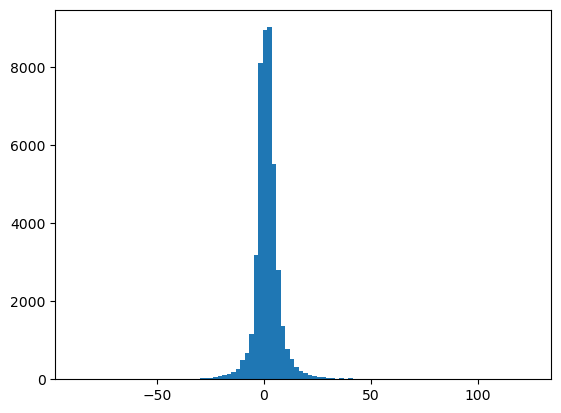

In [7]:
# create a neural network with 1 input layer, 1 hidden layer, and 1 output layer
num_neurons = 64
num_features = features.shape[1]
output_size = 1

model = torch.nn.Sequential(
    torch.nn.Linear(num_features, num_neurons),
    torch.nn.BatchNorm1d(num_neurons),
    torch.nn.Sigmoid(),
    torch.nn.Linear(num_neurons, num_neurons),
    torch.nn.BatchNorm1d(num_neurons),
    torch.nn.Sigmoid(),
    torch.nn.Linear(num_neurons, output_size),
    torch.nn.BatchNorm1d(output_size),
    torch.nn.Sigmoid(),
)


# init weights of the first layer to be normally distributed
torch.nn.init.normal_(model[0].weight, mean=0, std=1)
# reduce the weights of the first layer to be smaller
model[0].weight = torch.nn.Parameter(model[0].weight / 10)


def print_sizes(model, input_tensor):
    output = input_tensor
    for i, m in enumerate(model.children()):
        
        output = m(output)
        # if linear layer, plot a histogram of the output
        if i == 0 and isinstance(m, torch.nn.Linear):
            output_values = output.view(-1).tolist()
            plt.hist(output_values, bins=100);
        # print(m, output.shape)
    return output



# train the model on the entire dataset for production
# x = torch.tensor(features, dtype=torch.float32)
# x = x.view(-1, num_features)
# y = torch.tensor(target, dtype=torch.float32)
# y = y.view(-1, 1)

# training set
# x = torch.tensor(train_features, dtype=torch.float32)
x = train_features.clone()
x = x.view(-1, num_features)
# y = torch.tensor(train_target, dtype=torch.float32)
y = train_target.clone()
y = y.view(-1, 1)

sizes = print_sizes(model, x)


Iter: 0, Loss: 0.7219036221504211
Iter: 1000, Loss: 0.4495030343532562
Adjusted Learning rate: 0.0001
Iter: 2000, Loss: 0.44002607464790344


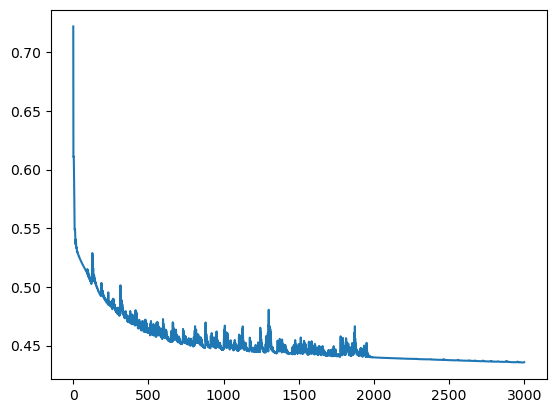

Iter: 2999, Loss: 0.43589502573013306


In [8]:
# create a loss function
loss_fn = F.binary_cross_entropy

# create a MSE loss function
# loss_fn = F.mse_loss


lossi = []

# create an optimizer
learning_rate = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_epochs = 3000

# train the model
for t in range(num_epochs):
    for layer in model:
        layer.train()
    
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    lossi.append(loss.item())
    if int(t == num_epochs * .65):
        learning_rate = 1e-4
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        print(f'Adjusted Learning rate: {learning_rate}')
    if t % 1000 == 0:
        print(f'Iter: {t}, Loss: {loss.item()}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# plot the loss
plt.plot(lossi)
plt.show()


print(f'Iter: {t}, Loss: {loss.item()}')


In [9]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model:
  layer.training = False

In [10]:
# Evaluate the model on the validation set
x = torch.tensor(val_features, dtype=torch.float32)
x = x.view(-1, num_features)
y = torch.tensor(val_target, dtype=torch.float32)
y = y.view(-1, 1)

# calculate the accuracy of the model on the validation set
with torch.no_grad():
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    y_pred_class = y_pred.round()
    acc = y_pred_class.eq(y).sum() / float(y.shape[0])

print(f'Validation accuracy: {acc:.2f}')


Validation accuracy: 0.80


/var/folders/1f/qjk02_3s70zd4sxj573fj7400000gn/T/ipykernel_38715/2426913016.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(val_features, dtype=torch.float32)
/var/folders/1f/qjk02_3s70zd4sxj573fj7400000gn/T/ipykernel_38715/2426913016.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(val_target, dtype=torch.float32)


In [11]:
# Calculate the accuracy of the model
with torch.no_grad():
    y_pred = model(x)
    y_pred_class = y_pred.round()
    acc = y_pred_class.eq(y).sum() / float(y.shape[0])

print(f'Training Accuracy: {acc.item()}')


Training Accuracy: 0.801047146320343


In [12]:
len(np.where(y_pred_class == 1)[0])

67

Baseline results:
epochs = 100 - a few thousand
features: {pclass, sex}: 0.61 accuracy with no predicted survivors

features: {pclass, sex, age}: 0.63 accuracy with 40 predicted survivors (some ones found in y_pred_class)

features: {pclass, sex, age  ... fare}: 0.69 accuracy with 265 predicted survivors.  It seems that fare has a lot of influence on survival as it raised the accuracy by 6% and the number of predicted survivors by 225.

Increasing the batch size also helped.  I went from 32 to 64 and got a 1% increase in accuracy.

In [13]:
# Evaluate model on test data

# Calculate the accuracy of the model

with torch.no_grad():
    test_df_features = get_features(test_df)
    test_df_features = torch.tensor(test_df_features, dtype=torch.float32)
    test_df_features = test_df_features.view(-1, test_df_features.shape[1])

    y_pred_test = model(test_df_features)
    y_pred_test_class = y_pred_test.round()
    y_pred_test_class = y_pred_test_class.view(-1)

print("# of dead: ",len(np.where(y_pred_test_class == 0)[0]))
print("# of survivors: ",len(np.where(y_pred_test_class == 1)[0]))

# of dead:  259
# of survivors:  158


/var/folders/1f/qjk02_3s70zd4sxj573fj7400000gn/T/ipykernel_38715/2786960409.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  important_features = torch.tensor(important_features, dtype=torch.float32)
/var/folders/1f/qjk02_3s70zd4sxj573fj7400000gn/T/ipykernel_38715/2119228742.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_df_features = torch.tensor(test_df_features, dtype=torch.float32)


In [14]:
test_predictions = torch.tensor(y_pred_test_class, dtype=torch.int32)
test_predictions.shape

# Write predictions to file
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': test_predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


/var/folders/1f/qjk02_3s70zd4sxj573fj7400000gn/T/ipykernel_38715/116046272.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_predictions = torch.tensor(y_pred_test_class, dtype=torch.int32)


Ideas for improving 
- add dropout
- add regularization
- add more layers
- add more neurons
- add more epochs
- add more features
- add more data
- use a transformer model

Done:
- created a validation set


# Random Forests

import sklearn.ensemble as ske

In [34]:
import sklearn.ensemble as ske

# # Train the model on training data
# model = ske.RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1)
# model.fit(train_features, train_target)

# # Evaluate the model on the validation set
# predictions = model.predict(val_features)


# # create a train and validation set
# train_features = torch.tensor(features[:700], dtype=torch.float32)
# train_target = torch.tensor(target[:700], dtype=torch.float32)

# val_features = features[700:]
# val_target = target[700:]

# print(predictions.shape)

# val_target = np.array(val_target).reshape(-1, 1)
# predictions = np.array(predictions).reshape(-1, 1)

# # # Calculate the accuracy of the model
# print(val_target.shape, predictions.shape)
# # val_target = val_target.tolist()

# # print(val_target)
# acc = model.score(val_features, val_target)
# print(f'Validation accuracy: {acc:.2f}')


# Train the model on entire dataset
model = ske.RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1)
model.fit(features, target)

print(f'features, target shape: {features.shape, target.shape}')

# Evaluate the model on the test set
test_df_features = get_features(test_df)
test_df_features = torch.tensor(test_df_features, dtype=torch.float32)
test_df_features = test_df_features.view(-1, test_df_features.shape[1])
test_df_features = torch.nan_to_num(test_df_features, nan=0.0, posinf=0.0, neginf=0.0)
# print(test_df_features)

# check if test_df_features has any NaN values
if test_df_features.isnan().any():
    print("NaN values in test_df_features")
    # replace NaN values with 0
    test_df_features = test_df_features[:, 0].fillna(0)


predictions = model.predict(test_df_features)

predictions = np.asarray(predictions, dtype=np.int32)
print(predictions[:5])
# # Write predictions to file
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('my_rfe_submission.csv', index=False)

features, target shape: (torch.Size([891, 3]), torch.Size([891]))
[0 0 0 0 1]


/var/folders/1f/qjk02_3s70zd4sxj573fj7400000gn/T/ipykernel_38715/2786960409.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  important_features = torch.tensor(important_features, dtype=torch.float32)
/var/folders/1f/qjk02_3s70zd4sxj573fj7400000gn/T/ipykernel_38715/3930946290.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_df_features = torch.tensor(test_df_features, dtype=torch.float32)
